In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np 

In [7]:
df = pd.read_csv('CernoxCalibration_Run.csv')
df

,Std Cernox: X115076 (Ohms),X103226 (Ohms),X111705 (Ohms)
0,57.627880,90.563864,85.453016
1,57.862207,90.979226,85.856367
2,58.096571,91.394116,86.259080
3,58.340287,91.825742,86.678370
4,58.593245,92.275269,87.114096
...,...,...,...
219,3518.570605,9888.396328,14737.444490
220,3801.270068,10903.886290,16420.557660
221,4121.511133,12083.032890,18393.657730
222,4479.012148,13435.060940,20679.897190


In [13]:
chart = pd.read_csv('StdThermometerCalibrationX115076.csv', header=1, names=['T', 'R'])
chart

,T,R
0,1.203822,12255.707750
1,1.300408,10434.815680
2,1.400242,9014.937533
3,1.598330,7048.511549
4,1.800920,5740.497896
...,...,...
79,310.149074,55.805311
80,315.151235,55.049166
81,320.145095,54.315302
82,326.140458,53.469994


In [18]:
def find_temp(res, chart):
    # find the temperature corresponding to the resistance according to the chart
    # the chart has two columns, T and R
    chart['diff'] = (chart['R'] - res).abs()
    closest_index = chart['diff'].idxmin()
    return chart.loc[closest_index]['T']

def find_res(temp, chart):
    chart['diff'] = (chart['T'] - temp).abs()
    closest_index = chart['diff'].idxmin()
    return chart.loc[closest_index]['R']

print(find_temp(7048, chart), find_res(1.6, chart))

1.598329868 7048.511549


In [ ]:
def set_temperature(temp=4, big_resistor=1e6, lockin=None, DC_source=None, v_goal=0.002, chart, tolerance = 0.1):

    res_goal = find_res(temp, chart)
    v_total = (v_goal / res_goal * big_resistor + v_goal)
    lockin.amplitude(v_total) # set the output voltage
    I = v_total / big_resistor

    def read_temperature():
        return find_temp(lockin.R() * I, chart)
    
    while abs(read_temperature() - temp) > tolerance:
        
            



In [15]:
class PIDController:
    def __init__(self, system, Kp=1, Ki=1, Kd=1):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def update(self, current_value):
        error = self.setpoint - current_value
        self.integral += error
        derivative = error - self.prev_error

        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative

        self.prev_error = error
        return output

In [39]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint, upper_range):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.prev_error = 0
        self.integral = 0
        self.upper_range = upper_range

    def update(self, current_value):
        error = self.setpoint - current_value
        self.integral += error
        derivative = error - self.prev_error

        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative

        self.prev_error = error

        return max(min(output, self.upper_range), 0)


    # Set the PID constants
Kp = 0.5
Ki = 0.1
Kd = 0.2


setpoint = 100  
upper_range = 5
tolerance = 0.01

pid = PIDController(Kp, Ki, Kd, setpoint, upper_range)


current_temperature = 80  # Initial temperature

history = []
output = []
i = 0
while abs(current_temperature - setpoint) > 1 and i <1000:
    control_output = pid.update(current_temperature)
    current_temperature += 0.9* (control_output-4) ** 2 - 0.5
    history.append(current_temperature)
    output.append(control_output)
    i+=1
print('done')

done


In [20]:
history[-1]

100.0

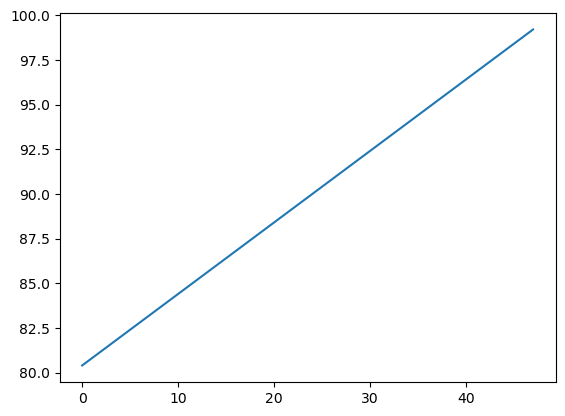

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.plot(history[:])
#plt.plot(output)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

In [7]:
import numpy as np 
import pyvisa
import time
from time import sleep
import qcodes as qc
from qcodes.dataset import do0d, load_or_create_experiment
from qcodes.instrument import Instrument
from qcodes.instrument_drivers.stanford_research import SR830
from qcodes.validators import Numbers
import pyvisa as visa
rm = visa.ResourceManager()
rm
#from qcodes_contrib_drivers.drivers.Lakeshore.Model_625 import Lakeshore625

<ResourceManager(<PyVisaLibrary('py')>)>

In [8]:
lockin_GPI = 7 
lockin_sensivity = ... #
lockin_ref_freq = 100 # stay at ~100 Hz, based on discussion with sandesh
lockin_ref_V = ... # ! what determines this? (think it does not matter, as long as we don't heat things up)
lockin_ref_phi = 0
lockin_tc = 0.03 # lock-in time constant, must be larger than 1 / (lock-in ref. frequency)
lockin_calib_time = 3 * lockin_tc # calibration time is ~3 * (time constant)

# CONNECT TO LOCK-IN
lockin = SR830('lockin', 'GPIB0::' + str(lockin_GPI) + '::INSTR') 
lockin.print_readable_snapshot() # check lock-in status

# SET LOCK-IN PARAMS
lockin.time_constant(lockin_tc)
lockin.sensitivity(lockin_sensitivity)
lockin.reference_source('internal')
lockin.set('amplitude', lockin_ref_V) # set reference amp
lockin.set('frequency', lockin_ref_freq)
lockin.set('phase', lockin_ref_phi) 
lockin.print_readable_snapshot() #

[lockin(SR830)] Could not connect at GPIB0::7::INSTR
Traceback (most recent call last):
  File "/Users/homefolder/miniconda3/lib/python3.10/site-packages/qcodes/instrument/visa.py", line 159, in _connect_and_handle_error
    visa_handle, visabackend, resource_manager = self._open_resource(
  File "/Users/homefolder/miniconda3/lib/python3.10/site-packages/qcodes/instrument/visa.py", line 188, in _open_resource
    resource = resource_manager.open_resource(address)
  File "/Users/homefolder/miniconda3/lib/python3.10/site-packages/pyvisa/highlevel.py", line 3292, in open_resource
    res.open(access_mode, open_timeout)
  File "/Users/homefolder/miniconda3/lib/python3.10/site-packages/pyvisa/resources/resource.py", line 281, in open
    self.session, status = self._resource_manager.open_bare_resource(
  File "/Users/homefolder/miniconda3/lib/python3.10/site-packages/pyvisa/highlevel.py", line 3217, in open_bare_resource
    return self.visalib.open(self.session, resource_name, access_mode,

ValueError: Please install linux-gpib (Linux) or gpib-ctypes (Windows, Linux) to use this resource type. Note that installing gpib-ctypes will give you access to a broader range of functionalities.
No module named 'gpib'

In [1]:
def resistance(V_measured, big_resistor, V_total):
    return V_measured * big_resistor / (V_total - V_measured)

In [41]:
resistance(1.13*1e-3, 104.4*1e3, 0.5)

236.47844127728666

In [82]:
range_low = 0.001
range_high = 0.003


In [5]:
 0.005 * 10000 / 0.5

100.0

In [4]:
60 / (10000+60)* 0.5 *1000

2.982107355864811